Для начала необходимо импортировать необходимые библиотеки:

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

Фото известного актера было найдено и загружено на **Google Диск**. Теперь надо его скачать:

In [ ]:
!wget -O actor.jpg 'https://drive.google.com/uc?export=download&id=1yf9h9oXySYKbGX6n0cOYw9Ajm-6P2m_q'

--2025-03-15 10:27:10--  https://drive.google.com/uc?export=download&id=1yf9h9oXySYKbGX6n0cOYw9Ajm-6P2m_q
Resolving drive.google.com (drive.google.com)... 142.251.16.139, 142.251.16.113, 142.251.16.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yf9h9oXySYKbGX6n0cOYw9Ajm-6P2m_q&export=download [following]
--2025-03-15 10:27:10--  https://drive.usercontent.google.com/download?id=1yf9h9oXySYKbGX6n0cOYw9Ajm-6P2m_q&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.111.132, 2607:f8b0:4004:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.111.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121369 (119K) [image/jpeg]
Saving to: ‘actor.jpg’

actor.jpg           100%[===================>] 118.52K  --.-KB/s    in 0.01s   

2

Тоже самое сделаем и с фотографией очков:

In [ ]:
!wget -O glasses.png 'https://drive.google.com/uc?export=download&id=1BScwoqkHfhbncxLHrrj5R87HUHdx9Eu8'

--2025-03-15 10:27:12--  https://drive.google.com/uc?export=download&id=1BScwoqkHfhbncxLHrrj5R87HUHdx9Eu8
Resolving drive.google.com (drive.google.com)... 172.253.62.139, 172.253.62.102, 172.253.62.101, ...
Connecting to drive.google.com (drive.google.com)|172.253.62.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1BScwoqkHfhbncxLHrrj5R87HUHdx9Eu8&export=download [following]
--2025-03-15 10:27:12--  https://drive.usercontent.google.com/download?id=1BScwoqkHfhbncxLHrrj5R87HUHdx9Eu8&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.111.132, 2607:f8b0:4004:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.111.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 969381 (947K) [image/png]
Saving to: ‘glasses.png’

glasses.png         100%[===================>] 946.66K  --.-KB/s    in 0.05s   



Определим загруженные фотографии в нашем коде. Важно для фотографии очков указать дополнительный параметр -1, который произведет загрузку с альфа-каналом. Этот параметр необходим для корректного наложения изображений с прозрачностью.

In [ ]:
#загрузка изображений
img = cv2.imread('actor.jpg')
img2 = img.copy()  # копия для работы
img3 = img.copy()  # для промежуточного результата с эллипсом и глазами
img4 = img.copy()  # для промежуточного результата с размытым лицом и глазами

glasses = cv2.imread('glasses.png', -1)  # -1 для загрузки с альфа-каналом

Далее необходимо загрузить каскады Хаара для поиска лиц и глаз. Они встроены в библиотеку **OpenCV**, поэтому достаточно просто обратиться к этим *xml-файлам* в коде, предварительно не скачивая их.

In [ ]:
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #каскад для лица
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml") #каскад для глаз

Для размытия лиц создадим функцию **blur**, в которой реализуем *Гауссово размытие*, примененим размытие только к области маски, где 255 — белые пиксели, обозначающие область, к которой нужно применить размытие.

In [ ]:
def blur(img_src, img_dest, mask, center, axes, eye_mask=None):
    blurred_face = cv2.GaussianBlur(img_src, (35, 35), 10) #здесь применяется Гауссово размытие
    img_dest[mask == 255] = blurred_face[mask == 255] #применение размытия только к области маски

    #если передана маска глаз, восстанавливаем глаза
    if eye_mask is not None:
        img_dest[eye_mask == 255] = img_src[eye_mask == 255]

    cv2.ellipse(img_dest, center, axes, 0, 0, 360, (0, 0, 255), 2) #рисование эллипса
    return img_dest

Функция **overlay_glasses** предназначена для наложения изображения очков (**resized_glasses**) на исходное изображение с учетом прозрачности (**альфа-канала**).

При извлечении альфа-канала поделим на 255.0, чтобы нормализовать значения альфа-канала в диапазон [0, 1].

При создание маски для области наложения очков `np.zeros_like` создает массив нулей того же размера, что и область изображения, куда будут наложены очки.

 `img[y_glasses_new:y_glasses_new + resized_glasses.shape[0], x_glasses_new:x_glasses_new + resized_glasses.shape[1]]` — это область исходного изображения, куда будут наложены очки.

  `alpha_channel[:, :, np.newaxis]` добавляет новую ось к альфа-каналу, чтобы его можно было использовать для всех трех цветовых каналов.

**img_changing** — это область исходного изображения, куда будут наложены очки.

**glasses_changing** — это изображение очков без альфа-канала.

**cv2.bitwise_and** вычисляет побитовое соединение двух массивов для каждого элемента или массива и скаляра.

**cv2.add** складывает два изображения: исходное изображение с удаленными областями под очками (img_changing) и изображение очков (glasses_changing).

После того как очки были наложены на выбранную область, эта область должна быть вставлена обратно в исходное изображение.

In [ ]:
def overlay_glasses(img, resized_glasses, x_glasses_new, y_glasses_new):
    #извлекает альфа-канал, который определяет прозрачность
    alpha_channel = resized_glasses[:, :, 3] / 255.0

    #создание маски для области наложения очков
    mask = np.zeros_like(img[y_glasses_new:y_glasses_new + resized_glasses.shape[0], x_glasses_new:x_glasses_new + resized_glasses.shape[1]])
    mask[:, :, :3] = alpha_channel[:, :, np.newaxis]

    #наложение очков на исходное изображение
    img_changing = img[y_glasses_new:y_glasses_new + resized_glasses.shape[0], x_glasses_new:x_glasses_new + resized_glasses.shape[1]]
    glasses_changing = resized_glasses[:, :, :3]

    #применение bitwise_and для наложения очков
    img_changing = cv2.bitwise_and(img_changing, img_changing, mask=(1 - alpha_channel).astype(np.uint8))
    glasses_changing = cv2.bitwise_and(glasses_changing, glasses_changing, mask=alpha_channel.astype(np.uint8))

    #сложение изображений
    img_changing = cv2.add(img_changing, glasses_changing)

    #вставка обратно в исходное изображение
    img[y_glasses_new:y_glasses_new + resized_glasses.shape[0], x_glasses_new:x_glasses_new + resized_glasses.shape[1]] = img_changing

    return img

**bboxes** — список распознанных лиц (координаты и  их размеры), к которому была применена функция **classifier_face.detectMultiScale** с рядом необходимых параметров.

**scaleFactor=1.1** — параметр масштабирования изображения для поиска лиц разных размеров.

**minNeighbors=5** — минимальное количество соседних прямоугольников, чтобы область считалась лицом.

**minSize=(30, 30)** — минимальный размер объекта, который будет считаться лицом.

In [ ]:
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))#выполнение распознавания лиц

Далее необходимо запустить цикл, в котором будет происходить обработка каждого найденного лица на фотографии.

**mask** — это бинарная маска (изображение того же размера, что и img2, но с одним каналом).

**cv2.ellipse**  рисует белый эллипс (255) на черном фоне (0). Этот эллипс определяет область, к которой будет применено размытие.

Функция **blur** применяет размытие к области лица, ограниченной **mask**. Размытие затрагивает только те пиксели, которые находятся внутри эллипса.

In [ ]:
for box in bboxes:
    x, y, width, height = box #для каждого обнаруженного лица извлекаются его координаты и размеры

    scale_factor = 0.9 #масштаб
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    center = (int(x + width / 2), int(y + height / 2 - height * 0.01)) #координаты центра эллипса, которые будет использоваться для размытия
    axes = (int(new_width / 2), int(new_height / 2 * 1.1)) #длины полуосей эллипса, рассчитанные на основе увеличенных размеров лица

    mask = np.zeros_like(img2[:, :, 0]) #бинарная маска
    cv2.ellipse(mask, center, axes, 0, 0, 360, 255, -1)

    img2 = blur(img, img2, mask, center, axes) #функция blur применяет размытие к области лица, ограниченной mask

    face = img[y:y + height, x:x + width] #область изображения, соответствующая лицу

Далее создадим переменную **eyes**, в которой применим функцию обнаружения глаз:

In [ ]:
eyes = classifier_eye.detectMultiScale(face) #использование каскадного классификатора Haar для обнаружения глаз

Далее проверяется, что обнаружено ровно два глаза. Это важно, так как очки накладываются только на пару глаз. Далее необходимо определить порядок глаз: левый глаз будет первым в списке, а правый глаз будет вторым в списке. Очки должны быть наложены на глаза в правильном порядке (сначала левый, потом правый).

**cv2.resize** изменяет размер изображения очков до `(int(w_glasses * scale_factor), int(h_glasses * scale_factor))`

Затем нужно вычислить координаты (**x_glasses_new, y_glasses_new**) для наложения очков таким образом, чтобы они были центрированы относительно области глаз. После масштабирования очки становятся больше, чем исходная область глаз. Чтобы очки были центрированы, нужно сместить их влево и вверх на половину разницы между новым и старым размером.

In [ ]:
if len(eyes) == 2:
        eyes = sorted(eyes, key=lambda x: x[0]) #сортировка списка eyes по координате x

        (x1, y1, w1, h1), (x2, y2, w2, h2) = eyes #координаты и размеры левого и правого глаза

        #рисование кругов вокруг глаз на img3
        for (ex, ey, ew, eh) in eyes:
            cv2.circle(img3, (x + ex + ew // 2, y + ey + eh // 2), ew // 2, (0, 255, 0), 2)

        #рисование эллипса вокруг лица на img3
        cv2.ellipse(img3, center, axes, 0, 0, 360, (0, 0, 255), 2)

        #создание маски для глаз
        eye_mask = np.zeros_like(mask)
        for (ex, ey, ew, eh) in eyes:
            cv2.circle(eye_mask, (x + ex + ew // 2, y + ey + eh // 2), ew // 2, 255, -1)

        #применение размытия к img4 (размытое лицо с глазами)
        img4 = blur(img, img4, mask, center, axes, eye_mask)

        x_glasses = min(x1, x2)
        y_glasses = min(y1, y2)
        w_glasses = max(x1 + w1, x2 + w2) - x_glasses #ширина области, охватывающей оба глаза
        h_glasses = max(y1 + h1, y2 + h2) - y_glasses #высота области, охватывающей оба глаза

        scale_factor = 1.3 #масштаб
        resized_glasses = cv2.resize(glasses, (int(w_glasses * scale_factor), int(h_glasses * scale_factor))) #изменяется размер

        #новые координаты для наложения очков
        x_glasses_new = x + x_glasses - int((w_glasses * scale_factor - w_glasses) / 2)
        y_glasses_new = y + y_glasses - int((h_glasses * scale_factor - h_glasses) / 2)

        img2 = overlay_glasses(img2, resized_glasses, x_glasses_new, y_glasses_new) #использование функции overlay_glasses

После выполнения основной части кода напишем код для вывода 2-ух изображений, где 1 - исходное, а 2 - изображение с распознанным лицом, наложенными блюром и фотографии очков:

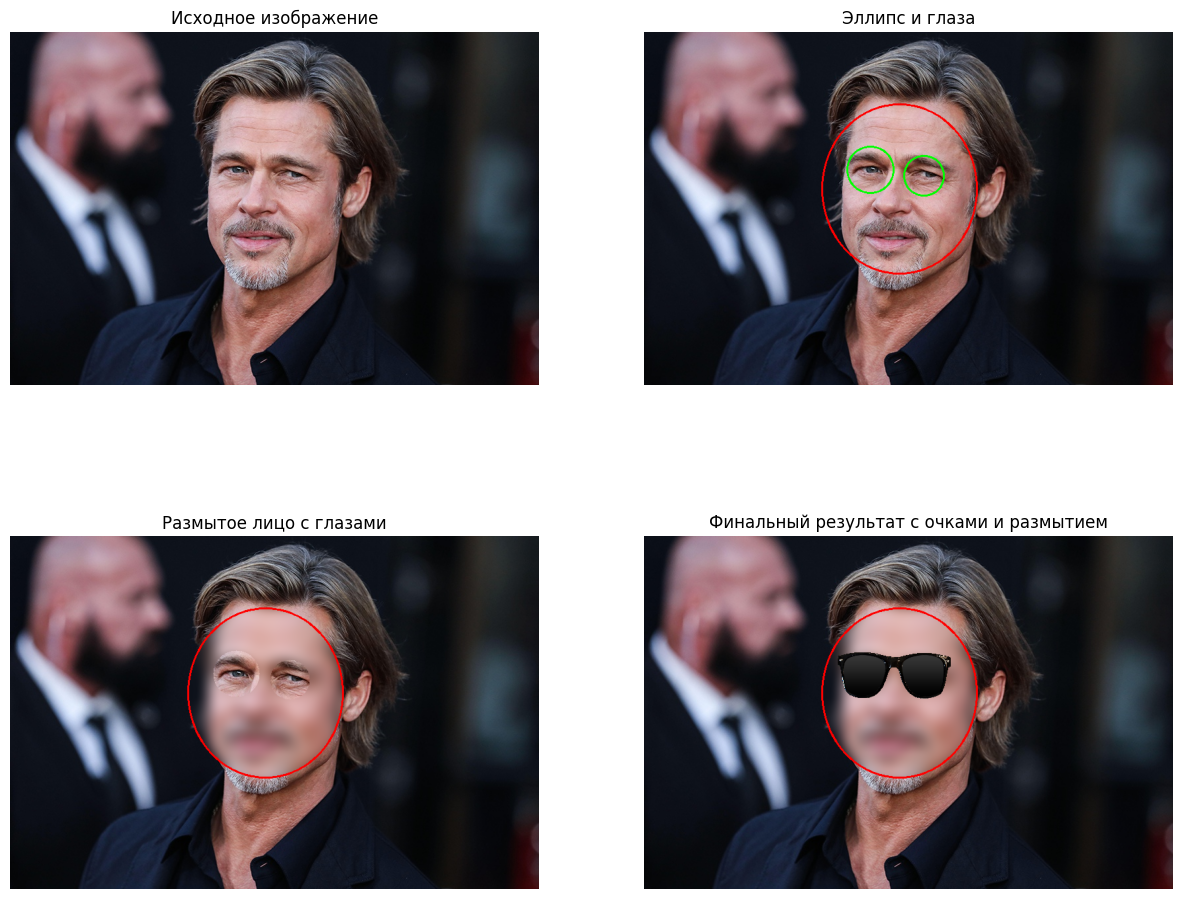

In [ ]:
#отображение результатов
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Исходное изображение')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax2.set_title('Эллипс и глаза')
ax2.axis('off')

ax3.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax3.set_title('Размытое лицо с глазами')
ax3.axis('off')

ax4.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax4.set_title('Финальный результат с очками и размытием')
ax4.axis('off')

plt.show()

Таким образом, в результате работы кода мы получили результат, соответсвующий поставленным задачам.